In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv

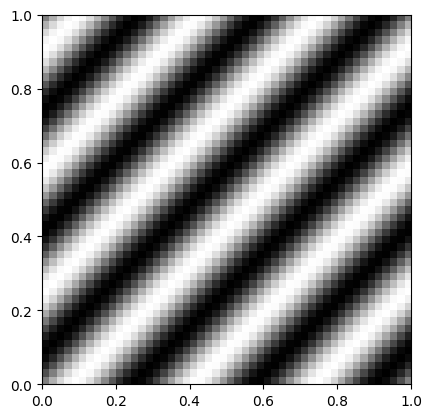

In [2]:
def gen_sinusoid(sx, sy, px, py, phase=0):
    xs = np.linspace(0, 1, sx)
    ys = np.linspace(0, 1, sy)

    X, Y = np.meshgrid(xs, ys)

    # Fix phase offset: phase should not be added to X and Y, but to the whole argument
    Z = np.exp(-2j * np.pi * (px * X + py * Y) + 1j * phase)

    return np.real(Z)

example = gen_sinusoid(50, 50, 3, 3, phase=np.pi/2)
plt.imshow(example, cmap='gray', extent=(0, 1, 0, 1))

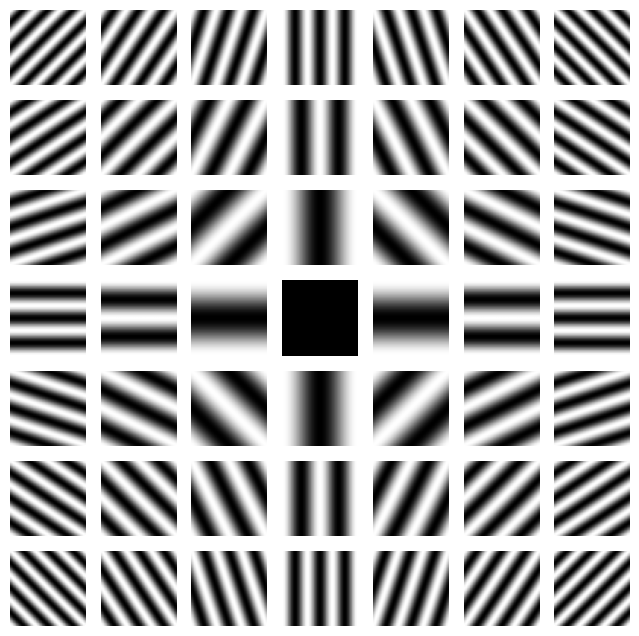

In [3]:
def gen_dft_indexes(num_freqs):
    size = num_freqs * 2 + 1
    xs = np.linspace(-num_freqs, num_freqs, size)
    ys = np.linspace(-num_freqs, num_freqs, size)
    X, Y = np.meshgrid(xs, ys)
    Z = np.stack((X, Y), axis=-1)
    return Z


ex_freqs = 3
ex_indexes = gen_dft_indexes(ex_freqs)
ex_size = 2 * ex_freqs + 1
plt.subplots(ex_size, ex_size, figsize=(8, 8))

for c,(x,y) in enumerate(ex_indexes.reshape(-1, 2)):
    sinusoid = gen_sinusoid(50, 50, y, x)
    plt.subplot(ex_size, ex_size, c + 1)
    plt.imshow(sinusoid, cmap='gray')
    plt.axis('off')

In [4]:
def optimize_index_by_symmetry(indexes):
    mask = np.zeros(indexes.shape[:-1], dtype=bool)
    center = indexes.shape[0] // 2

    mask[center+1:, :center] = True
    mask[center:, center:] = True

    return indexes[mask]

In [9]:
freqencies = 20
indexes = gen_dft_indexes(freqencies)
indexes_opt = optimize_index_by_symmetry(indexes)

video = cv.VideoWriter('sinusoids.mp4', cv.VideoWriter_fourcc(*'H264'), 24 , (256, 256), False)
for c, (x, y) in enumerate(indexes_opt):
    for phi in [0, np.pi / 2, np.pi, 3 * np.pi / 2]:
        sinusoid = gen_sinusoid(256, 256, y, x, phase=phi)
        sinusoid = (sinusoid * 127 + 128).astype(np.uint8)
        video.write(sinusoid)
video.release()

number_of_frames = len(indexes_opt) * 4

print(f'Number of frames: {number_of_frames}')

Number of frames: 3364


In [5]:
def load_video(filename):
    video = cv.VideoCapture(filename)

    frames = []

    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        frame_ycrcb = cv.cvtColor(frame, cv.COLOR_BGR2YCrCb)
        frames.append(frame_ycrcb[:, :, 0])
    
    frames = np.stack(frames, axis=0).astype(np.float64)
    video.release()
    return frames

(np.float64(-0.5), np.float64(199.5), np.float64(149.5), np.float64(-0.5))

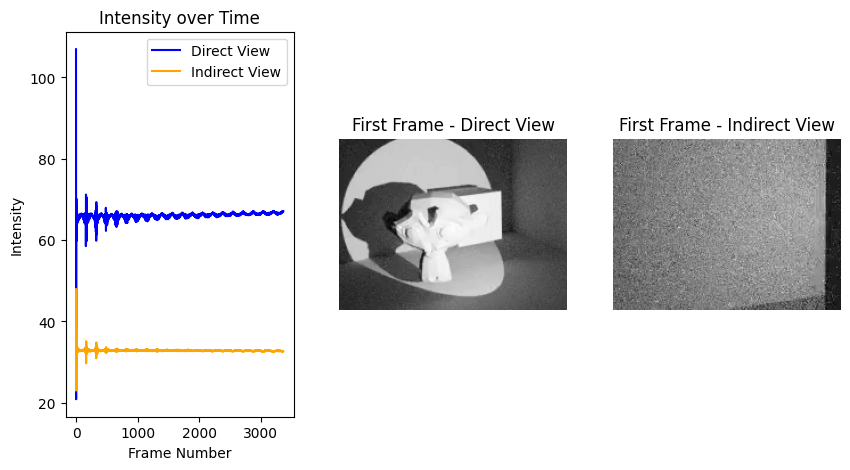

In [6]:
frames_direct = load_video("render_direct_view.mp4")
frames_indirect = load_video("render_indirect_view.mp4")


frames_direct_intensity = np.mean(frames_direct, axis=(1, 2))
frames_indirect_intensity = np.mean(frames_indirect, axis=(1, 2))

plt.subplots(1, 3, figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.plot(frames_direct_intensity, label='Direct View', color='blue')
plt.plot(frames_indirect_intensity, label='Indirect View', color='orange')
plt.title('Intensity over Time')
plt.xlabel('Frame Number')
plt.ylabel('Intensity')
plt.legend()

plt.subplot(1, 3, 2)
plt.imshow(frames_direct[0], cmap='gray')
plt.title('First Frame - Direct View')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(frames_indirect[0], cmap='gray')
plt.title('First Frame - Indirect View')
plt.axis('off')

In [7]:
def set_fourier_spectrum(spectrum, indexes, x, y, value):
    mask_b = np.logical_and(indexes[:, :, 0] == x, indexes[:, :, 1] == y)
    mask_a = np.logical_and(indexes[:, :, 0] == -x, indexes[:, :, 1] == -y)
    np.putmask(spectrum, mask_a, value)
    np.putmask(spectrum, mask_b, value.conjugate())


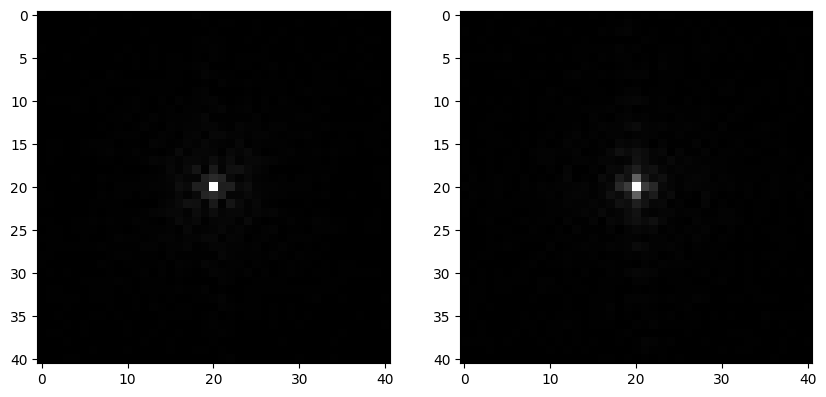

In [13]:
fourier_spectrum_direct = np.zeros(indexes.shape[:-1], dtype=np.complex128)
fourier_spectrum_indirect = np.zeros(indexes.shape[:-1], dtype=np.complex128)

for c, (x, y) in enumerate(indexes_opt):
    phases_direct = frames_direct_intensity[4*c:4*c+4]
    phases_indirect = frames_indirect_intensity[4*c:4*c+4]
    
    value_direct = complex((phases_direct[0] - phases_direct[2]), -(phases_direct[3]-phases_direct[1]))
    value_indirect = complex((phases_indirect[0] - phases_indirect[2]), -(phases_indirect[3]-phases_indirect[1]))

    set_fourier_spectrum(fourier_spectrum_direct, indexes, y, x, value_direct)
    set_fourier_spectrum(fourier_spectrum_indirect, indexes, y, x, value_indirect)


shifted_spectrum_direct = np.fft.ifftshift(fourier_spectrum_direct)
shifted_spectrum_indirect = np.fft.ifftshift(fourier_spectrum_indirect)

plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(fourier_spectrum_direct), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(np.abs(fourier_spectrum_indirect), cmap='gray')
    

(np.float64(-0.5), np.float64(40.5), np.float64(40.5), np.float64(-0.5))

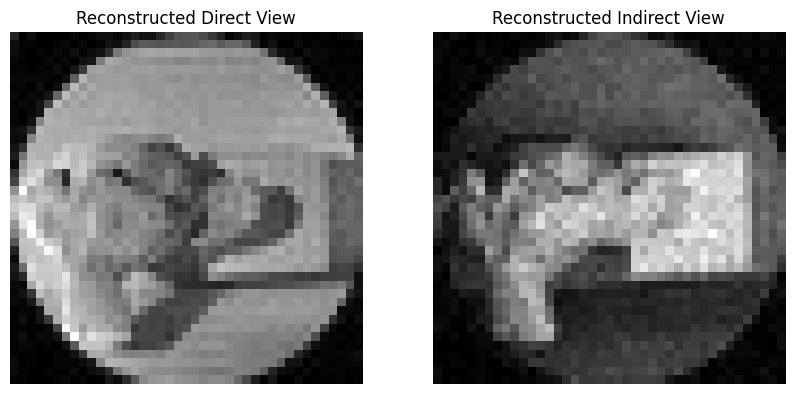

In [14]:
reconstructed_direct = np.abs(np.fft.ifft2((shifted_spectrum_direct)))
reconstructed_indirect = np.abs(np.fft.ifft2((shifted_spectrum_indirect)))

plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow((reconstructed_direct), cmap='gray')
plt.title('Reconstructed Direct View')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow((reconstructed_indirect), cmap='gray')
plt.title('Reconstructed Indirect View')
plt.axis('off')